In [1]:
import sys
sys.path.insert(0, '/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages')
#sys.path.insert(0, '/path/to/your/cloned/gcr-catalogs')

import numpy as np
from GCR import GCRQuery
import GCRCatalogs

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
catalog = GCRCatalogs.load_catalog('dc2_coadd_run1.1p')

In [4]:
sorted(catalog.list_all_quantities())

['dec',
 'mag_g_lsst',
 'mag_i_lsst',
 'mag_r_lsst',
 'mag_u_lsst',
 'mag_y_lsst',
 'mag_z_lsst',
 'magerr_g_lsst',
 'magerr_i_lsst',
 'magerr_r_lsst',
 'magerr_u_lsst',
 'magerr_y_lsst',
 'magerr_z_lsst',
 'ra']

In [5]:
sorted(catalog.list_all_native_quantities())[:20]

['base_Blendedness_abs_child_xx',
 'base_Blendedness_abs_child_xy',
 'base_Blendedness_abs_child_yy',
 'base_Blendedness_abs_flux',
 'base_Blendedness_abs_flux_child',
 'base_Blendedness_abs_flux_parent',
 'base_Blendedness_abs_parent_xx',
 'base_Blendedness_abs_parent_xy',
 'base_Blendedness_abs_parent_yy',
 'base_Blendedness_flag',
 'base_Blendedness_flag_noCentroid',
 'base_Blendedness_flag_noShape',
 'base_Blendedness_old',
 'base_Blendedness_raw_child_xx',
 'base_Blendedness_raw_child_xy',
 'base_Blendedness_raw_child_yy',
 'base_Blendedness_raw_flux',
 'base_Blendedness_raw_flux_child',
 'base_Blendedness_raw_flux_parent',
 'base_Blendedness_raw_parent_xx']

In [6]:
catalog.available_tracts_and_patches[:20]

[{'patch': '0,1', 'tract': 4430},
 {'patch': '0,2', 'tract': 4430},
 {'patch': '0,3', 'tract': 4430},
 {'patch': '0,4', 'tract': 4430},
 {'patch': '0,5', 'tract': 4430},
 {'patch': '0,6', 'tract': 4430},
 {'patch': '0,7', 'tract': 4430},
 {'patch': '1,1', 'tract': 4430},
 {'patch': '1,2', 'tract': 4430},
 {'patch': '1,3', 'tract': 4430},
 {'patch': '1,4', 'tract': 4430},
 {'patch': '1,5', 'tract': 4430},
 {'patch': '1,6', 'tract': 4430},
 {'patch': '1,7', 'tract': 4430},
 {'patch': '2,1', 'tract': 4430},
 {'patch': '2,2', 'tract': 4430},
 {'patch': '2,3', 'tract': 4430},
 {'patch': '2,4', 'tract': 4430},
 {'patch': '2,5', 'tract': 4430},
 {'patch': '2,6', 'tract': 4430}]

In [7]:
catalog.available_tracts

[4430,
 4431,
 4432,
 4433,
 4636,
 4637,
 4638,
 4639,
 4640,
 4848,
 4849,
 4850,
 4851,
 4852,
 5062,
 5063,
 5064,
 5065,
 5066]

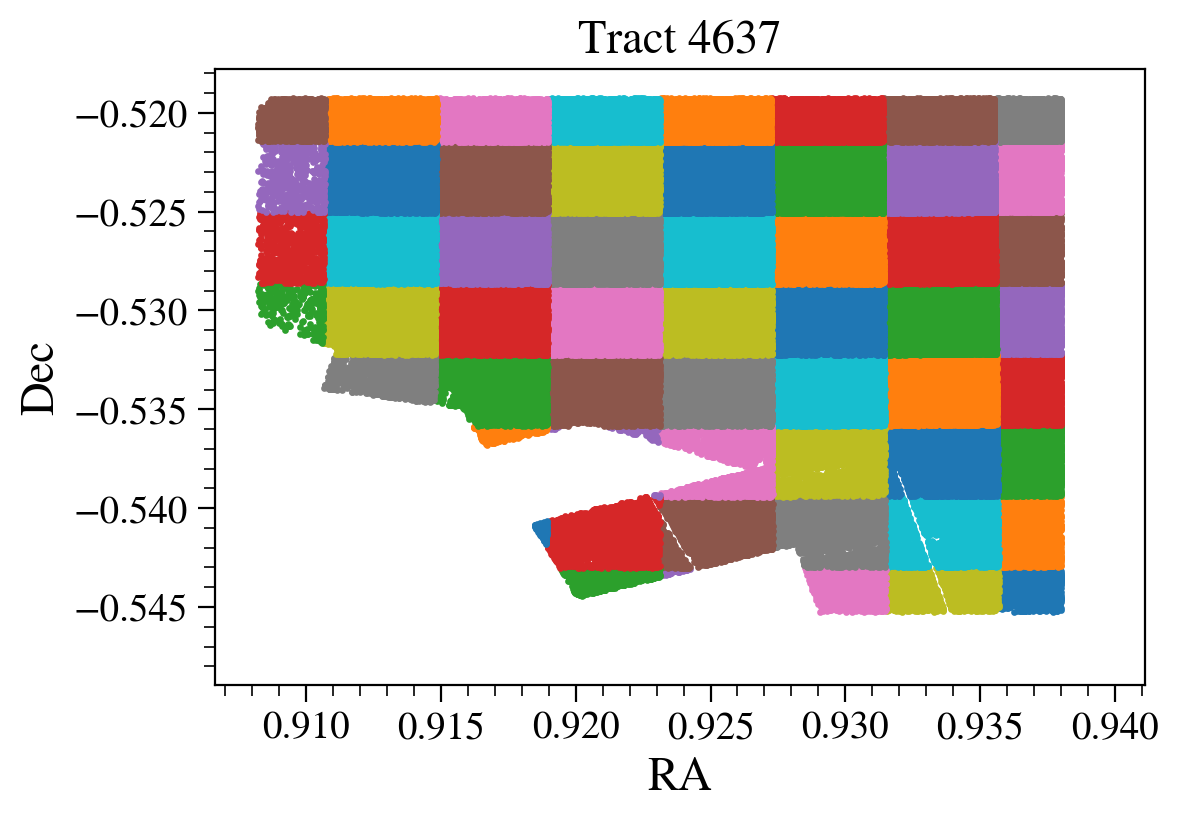

In [8]:
tract_number = 4637
for d in catalog.get_quantities(['ra', 'dec'], native_filters=[(lambda x: x==tract_number, 'tract')], return_iterator=True):
    plt.scatter(d['ra'], d['dec'], s=2);
plt.xlabel('RA');
plt.ylabel('Dec');
plt.title('Tract {}'.format(tract_number));

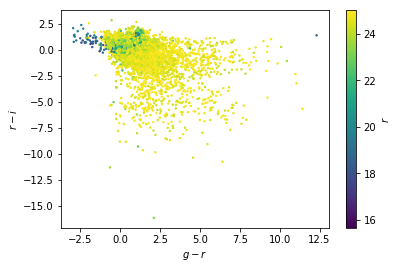

In [9]:
tract_number = 4637
mags = ['mag_g_lsst', 'mag_r_lsst', 'mag_i_lsst']
d = catalog.get_quantities(mags, 
                           filters=[GCRQuery((np.isfinite, key)) for key in mags] + ['mag_r_lsst < 25'], 
                           native_filters=[(lambda x: x==tract_number, 'tract')])
c = plt.scatter(d['mag_g_lsst'] - d['mag_r_lsst'], d['mag_r_lsst'] - d['mag_i_lsst'], s=2, c=d['mag_r_lsst']);
plt.colorbar(c, label='$r$')
plt.xlabel('$g-r$');
plt.ylabel('$r-i$');


Here's an example from https://github.com/LSSTDESC/DC2_Repo/blob/issues/155/Validation/lensing_distributions.ipynb

In [10]:
catalog.add_quantity_modifier('i_mag_cmodel', 
                              (lambda x: -2.5 * np.log10(x) + 27.0, 'i_modelfit_CModel_flux'), 
                              overwrite=True)
catalog.add_quantity_modifier('i_SN_cmodel', 
                              (np.divide, 'i_modelfit_CModel_flux', 'i_modelfit_CModel_fluxSigma'), 
                              overwrite=True)
catalog.add_quantity_modifier('HSM_res', 
                              'ext_shapeHSM_HsmShapeRegauss_resolution', 
                              overwrite=True)
catalog.add_quantity_modifier('HSM_ell', 
                              (np.hypot, 'ext_shapeHSM_HsmShapeRegauss_e1', 'ext_shapeHSM_HsmShapeRegauss_e2'), 
                              overwrite=True)
catalog.add_quantity_modifier('psf_size', 
                              (lambda xx, yy, xy: 0.168*2.355*(xx*yy - xy*xy)**0.25, 'i_base_SdssShape_psf_xx', 'i_base_SdssShape_psf_yy', 'i_base_SdssShape_psf_xy'),
                              overwrite=True)

In [11]:
# Lensing cuts based on Mandelbaum 2017 (arxiv 1705.06745)

lensing_cuts = [
    ~GCRQuery((np.isnan, 'i_modelfit_CModel_flux')), # (from this and below) remove nan entries
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_resolution')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e1')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e2')),
    GCRQuery('detect_isPrimary'), # (from this and below) basic flag cuts 
    ~GCRQuery('deblend_skipped'),
    ~GCRQuery('base_PixelFlags_flag_edge'),
    ~GCRQuery('base_PixelFlags_flag_interpolatedCenter'),
    ~GCRQuery('base_PixelFlags_flag_saturatedCenter'),
    ~GCRQuery('base_PixelFlags_flag_crCenter'),
    ~GCRQuery('base_PixelFlags_flag_bad'),
    ~GCRQuery('base_PixelFlags_flag_suspectCenter'),
    ~GCRQuery('base_PixelFlags_flag_clipped'),
    ~GCRQuery('ext_shapeHSM_HsmShapeRegauss_flag'),
    GCRQuery('i_SN_cmodel >= 10'), # (from this and below) cut on object properties
    GCRQuery('HSM_res >= 0.3'),
    GCRQuery('HSM_ell < 2.0'),
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4'),
    GCRQuery('i_mag_cmodel < 24.5'), # FIXME: Doesnt have exinction correction
    GCRQuery('base_Blendedness_abs_flux < 10**(-0.375)'),
]

In [12]:
tract_number = 4637
quantities = ['i_mag_cmodel', 'i_SN_cmodel', 'HSM_res', 'HSM_ell', 'psf_size']
d = catalog.get_quantities(quantities, 
                           filters=lensing_cuts, 
                           native_filters=[(lambda x: x==tract_number, 'tract')])

/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


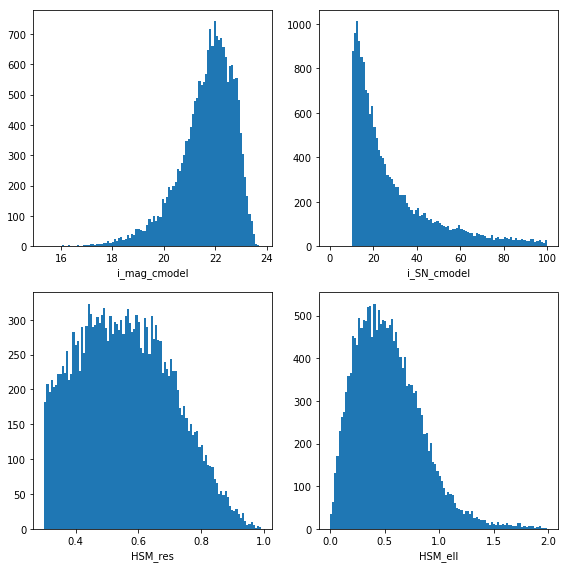

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))
for ax_this, quantity in zip(ax.flat, quantities):
    ax_this.hist(d[quantity], 100, range=([0,100] if quantity=='i_SN_cmodel' else None))
    ax_this.set_xlabel(quantity)
fig.tight_layout()

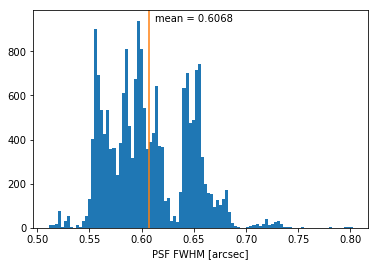

In [14]:
fig, ax = plt.subplots()
ax.hist(d['psf_size'], 100);
mean = d['psf_size'].mean()
ax.axvline(mean, c='C1');
ax.text(mean*1.01, ax.get_ylim()[1]*0.95, 'mean = {:.4g}'.format(mean));
ax.set_xlabel('PSF FWHM [arcsec]');